# Imports

In [30]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import re, string

# Data

For this example you need to download twitter data from Kaggle: https://www.kaggle.com/kazanova/sentiment140

Context \\
\
This is the sentiment140 dataset. It contains 1,600,000 tweets extracted using the twitter api . The tweets have been annotated (0 = negative, 4 = positive) and they can be used to detect sentiment. \\
\
Content \\
\
It contains the following 6 fields:
* target: the polarity of the tweet (0 = negative, 4 = positive)

* ids: The id of the tweet ( 2087)

* date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)

* flag: The query (lyx). If there is no query, then this value is NO_QUERY.

* user: the user that tweeted (robotickilldozr)

* text: the text of the tweet (Lyx is cool)

Acknowledgements \\
The official link regarding the dataset with resources about how it was generated is [here](http://%20http//help.sentiment140.com/for-students/) \\
The official paper detailing the approach is [here](http://bhttp//cs.stanford.edu/people/alecmgo/papers/TwitterDistantSupervision09.pdf)

Citation: Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.

In [31]:
df = pd.read_csv("df_full.csv"
                        )

In [32]:
df.head()

,score,sentiment,Text
0,1,Positive,ZUKA ZAMA! 🇺🇸🇺🇸🇺🇸❤️🤍💙
1,1,Positive,Zip ties!
2,1,Positive,Zero sugar options would be nice as well
3,1,Positive,Zendaya by cozz ft. J Cole 🐐
4,1,Positive,Zayunmmmm who are these people 🥵😍


In [33]:
df['target'] =df['score']

In [34]:
df['target']=df['target'].astype('category')

We have two classes in the dataset

In [35]:
df.target.unique()

[1, 0]
Categories (2, int64): [0, 1]

Let's check how equally distributed those classes are.

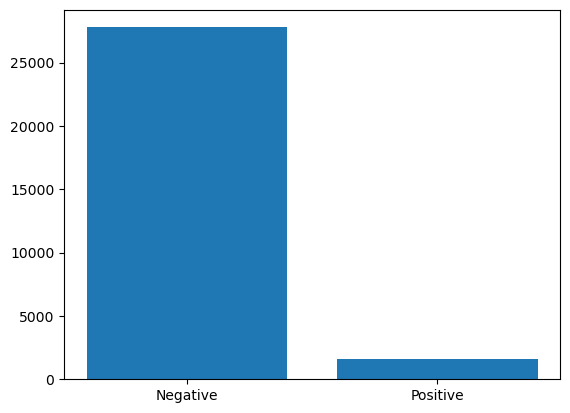

In [36]:
classes = df.target.unique()
counts = []

for i in classes:
  count = len(df[df.target==i])
  counts.append(count)

plt.bar(['Negative', 'Positive'], counts)
plt.show()

## Data cleaning

In [37]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#Stop Words: A stop word is a commonly used word (such as “the”, “a”, “an”, “in”) 
#that a search engine has been programmed to ignore,
#both when indexing entries for searching and when retrieving them as the result of a search query.
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/iremindergand/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [38]:
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
def process_text(Text):
    Text=Text[0:].lower()
    # Removing all URls 
    Text = re.sub(urlPattern,'',Text)
    # Removing all @username.
    Text = re.sub(userPattern,'', Text) 
    #Remove punctuations
    Text = Text.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(Text)
    #tokens = [w for w in tokens if len(w)>2]
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopwords.words("english")]
    #reducing a word to its word stem 
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

In [39]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", 
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
     "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
}


def convert_abbrev_in_text(Text):
    t=[]
    words=Text.split()
    t = [abbreviations[w] if w in abbreviations.keys() else w for w in words]
    return ' '.join(t) 

In [40]:
df['processed_text'] = df['Text'].apply(lambda x: convert_abbrev_in_text(x))
df['processed_text'] = df['processed_text'].apply(lambda x: process_text(x))
print('Text Preprocessing complete.')
df

Text Preprocessing complete.


,score,sentiment,Text,target,processed_text
0,1,Positive,ZUKA ZAMA! 🇺🇸🇺🇸🇺🇸❤️🤍💙,1,zuka zama 🇺🇸🇺🇸🇺🇸❤️🤍💙
1,1,Positive,Zip ties!,1,zip tie
2,1,Positive,Zero sugar options would be nice as well,1,zero sugar option would nice well
3,1,Positive,Zendaya by cozz ft. J Cole 🐐,1,zendaya cozz foot cole
4,1,Positive,Zayunmmmm who are these people 🥵😍,1,zayunmmmm people 🥵😍
...,...,...,...,...,...
29400,1,Positive,- jigsaw puzzles 1000 piece preferred \n- maki...,1,jigsaw puzzle 1000 piece preferred making move...
29401,1,Positive,- Having the Squad that I do. They are my MOD ...,1,squad mod family enjoyed seeing people team gr...
29402,1,Positive,- 😝💗Nintendo switch🥺pls\n🚫Please no chocolate ...,1,😝💗nintendo switch🥺pls 🚫please chocolate candy🚫...
29403,1,Positive,Thanks !,1,thanks


In [41]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [42]:
df['processed_text'] = df['processed_text'].apply(lambda x: remove_emoji(x))


# Vectorize
What we need to do now is to split the data into training and testing datasets and vectorize (essentialy turning text into number vectors) the text. 

In [43]:
x = df.processed_text.values
y = df.target.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=32, stratify= y)

Vectorizing

In [44]:
vectorizer = CountVectorizer()
vectorizer.fit(x_train)

X_train = vectorizer.transform(x_train)
X_test = vectorizer.transform(x_test)

Our vectorized dataset will consist of index of each word that is used in training dataset. We can check how it looks by simply printing the first tweet both as it was and after vectorizing it.

In [45]:
print(x_train[0], '\n', X_train[0])

even work today got eye everywhere  
   (0, 4317)	1
  (0, 4335)	1
  (0, 4445)	1
  (0, 5222)	1
  (0, 11601)	1
  (0, 12613)	1


Now the sparse matrix you see corresponds to index of the word and count of it in the tweet. Keep in mind it's not in the same order as in the tweet. You can check the corresponding values using vocabulary of the vectorizer.

# Modelling
The model that we use here is a simple [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression). \\


In [46]:
classifier = LogisticRegression(max_iter=20000)
classifier.fit(X_train, y_train)

score = classifier.score(X_test, y_test)

print("Accuracy:", score)

Accuracy: 0.948308110865499


#Confussion matrix
Before jumping into other models it's always good to check how our model performs in different classes. For that we can use [confussion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).

It essentially shows how many times model predicted which class and how many of those times the class it slected was the right one. Here columns are true values and lines are predicted values.

In [47]:
y_pred = classifier.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=df.target.unique())
df_cm = pd.DataFrame(cm, index=df.target.unique(), columns=df.target.unique())
df_cm

,1,0
1,5506,53
0,251,71


For a better understanding you could use percentage expression.

In [48]:
df_cm_percentage = df_cm.copy()
for i in df_cm_percentage:
  df_cm_percentage[i]/=df_cm_percentage[i].sum()

df_cm_percentage

,1,0
1,0.956401,0.427419
0,0.043599,0.572581


Good, so in the end model learnt to classify both classes about the same. Even though we are using Logistic Regression as a base measure to check if the problem is solvable and what results we might expect some insights can be derived here:

1.   Classes are not evenly distributed, thus we overtrain on one class compared to the other

2.   Both classes are not predicted equally well



# Test

Now we need to check if it actually works. Let's just copy a comment in one of Trump's [tweets](https://twitter.com/realDonaldTrump/status/1315835556081868801). 

The comment is: 
PATRIOTIC AMERICANS STAND PROUDLY WITH PRESIDENT TRUMP!!

In [49]:
tweet = 'PATRIOTIC AMERICANS STAND PROUDLY WITH PRESIDENT TRUMP!!'
vectTweet = vectorizer.transform(np.array([tweet]))  # vectorizes the tweet using our vectorizer

prediction = classifier.predict(vectTweet)  # predicts class of the tweet
print('Tweet is', 'positive' if prediction[0]==1 else 'negative')

Tweet is positive


Good, so our model is right here. Let's just make sure our model works okay with very specific sentiments.

In [50]:
tweetList = ['Best tweet ever!', 'Mondays are the worst...']
vectTweet = vectorizer.transform(np.array(tweetList))  # vectorizes the tweet using our vectorizer

prediction = classifier.predict(vectTweet)  # predicts class of the tweet
for enum, i in enumerate(tweetList):
  print(i, '| This tweet is', 'positive' if prediction[enum]==1 else 'negative')

Best tweet ever! | This tweet is positive
Mondays are the worst... | This tweet is positive


In [51]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks


    box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_labels,group_counts)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


In [52]:
#Get the confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)

[[  71  251]
 [  53 5506]]


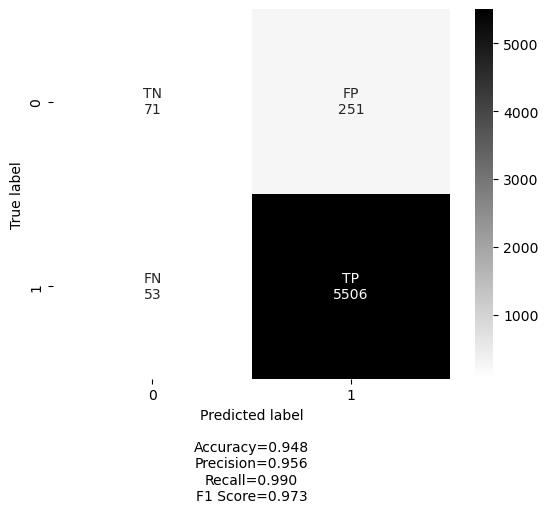

In [53]:
labels = ['TN','FP','FN','TP']
categories = ["0", "1"]
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='binary')

In [54]:
df_cm_percentage = df_cm.copy()
for i in df_cm_percentage:
  df_cm_percentage[i]/=df_cm_percentage[i].sum()

df_cm_percentage

,1,0
1,0.956401,0.427419
0,0.043599,0.572581


In [55]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.57      0.22      0.32       322
           1       0.96      0.99      0.97      5559

    accuracy                           0.95      5881
   macro avg       0.76      0.61      0.65      5881
weighted avg       0.94      0.95      0.94      5881

